# MON NAIVE BAYES

In [ ]:
%pip install keras
%pip install pandas
%pip install matplotlib
%pip install tensorflow
%pip install scikit-learn
%pip install --upgrade keras


In [ ]:
%pip install spacy nltk
!python -m spacy download en_core_web_sm


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import nltk
from nltk.corpus import stopwords, words
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, LancasterStemmer, WordNetLemmatizer
import spacy
import string
from spacy.lang.en import English
from spacy.tokens import Doc
from spacy.tokenizer import Tokenizer
from spacy.lang.en.stop_words import STOP_WORDS

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

from tensorflow import keras
from keras.utils import to_categorical
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

from keras.optimizers import Adam
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from keras.layers import Dense, LSTM, Embedding, Bidirectional

# Modelling
from sklearn.model_selection import train_test_split,KFold, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score,confusion_matrix, classification_report
from sklearn.pipeline import make_pipeline
from sklearn.metrics import f1_score
from sklearn.svm import SVC



In [24]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('words')

stop_words = set(stopwords.words("english"))
lemmatizer= WordNetLemmatizer()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\nickh\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\nickh\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\nickh\AppData\Roaming\nltk_data...
[nltk_data] Downloading package words to
[nltk_data]     C:\Users\nickh\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!


In [18]:
train = pd.read_csv('./train.txt', names=['text', 'emotion'], sep=';')
test = pd.read_csv('./test.txt', names=['text', 'emotion'], sep=';')
val = pd.read_csv('./val.txt', names=['text', 'emotion'], sep=';')

print(train.shape)
print(test.shape)
print(val.shape)

(16000, 2)
(2000, 2)
(2000, 2)


Data Preparation

In [19]:
def prepare_data(data):
  # Hapus data yg kosong
  data.dropna(inplace = True)

  # Hapus data duplikat
  data.drop_duplicates(inplace = True)

  # hapus data dengan text yang sama tapi emosi berbeda
  index = data[data['text'].duplicated() == True].index
  data.drop(index, axis = 0, inplace = True)
  data.reset_index(inplace=True, drop = True)

  return data

In [20]:
train = prepare_data(train)
test = prepare_data(test)
val = prepare_data(val)

print(train.shape)
print(test.shape)
print(val.shape)

(15969, 2)
(2000, 2)
(1998, 2)


In [21]:
train['emotion'].value_counts()

emotion
joy         5350
sadness     4664
anger       2155
fear        1933
love        1299
surprise     568
Name: count, dtype: int64

Normalize Text

In [22]:
def lemmatization(text):
    lemmatizer= WordNetLemmatizer()

    text = text.split()

    text=[lemmatizer.lemmatize(y) for y in text]
    
    return " " .join(text)

def remove_stop_words(text):

    Text=[i for i in str(text).split() if i not in stop_words]
    return " ".join(Text)

def Removing_numbers(text):
    text=''.join([i for i in text if not i.isdigit()])
    return text

def lower_case(text):
    
    text = text.split()

    text=[y.lower() for y in text]
    
    return " " .join(text)

def Removing_punctuations(text):
    ## Remove punctuations
    text = re.sub('[%s]' % re.escape("""!"#$%&'()*+,،-./:;<=>؟?@[\]^_`{|}~"""), ' ', text)
    text = text.replace('؛',"", )
    
    ## remove extra whitespace
    text = re.sub('\s+', ' ', text)
    text =  " ".join(text.split())
    return text.strip()

def Removing_urls(text):
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    return url_pattern.sub(r'', text)

def remove_small_sentences(df):
    for i in range(len(df)):
        if len(df.text.iloc[i].split()) < 3:
            df.text.iloc[i] = np.nan
            
def normalize_text(df):
    df.text=df.text.apply(lambda text : lower_case(text))
    df.text=df.text.apply(lambda text : remove_stop_words(text))
    df.text=df.text.apply(lambda text : Removing_numbers(text))
    df.text=df.text.apply(lambda text : Removing_punctuations(text))
    df.text=df.text.apply(lambda text : Removing_urls(text))
    df.text=df.text.apply(lambda text : lemmatization(text))
    return df

def normalized_sentence(sentence):
    sentence= lower_case(sentence)
    sentence= remove_stop_words(sentence)
    sentence= Removing_numbers(sentence)
    sentence= Removing_punctuations(sentence)
    sentence= Removing_urls(sentence)
    sentence= lemmatization(sentence)
    return sentence

In [25]:
train= normalize_text(train)
test= normalize_text(test)
val= normalize_text(val)

In [26]:
accuracies = []

In [27]:
clf = make_pipeline(
    TfidfVectorizer(),
    LogisticRegression(solver='liblinear', random_state=0)
)

clf.fit(train['text'], train['emotion'])

y_pred=clf.predict(test['text'])
accuracies.append(accuracy_score(test['emotion'], y_pred))
print(classification_report(test['emotion'], y_pred))

              precision    recall  f1-score   support

       anger       0.89      0.83      0.86       275
        fear       0.88      0.77      0.82       224
         joy       0.83      0.96      0.89       695
        love       0.86      0.60      0.70       159
     sadness       0.90      0.93      0.92       581
    surprise       0.94      0.47      0.63        66

    accuracy                           0.87      2000
   macro avg       0.88      0.76      0.80      2000
weighted avg       0.87      0.87      0.86      2000



In [28]:
clf = make_pipeline(
    TfidfVectorizer(),
    DecisionTreeClassifier(random_state=0)
)

clf.fit(train['text'], train['emotion'])

y_pred=clf.predict(test['text'])
accuracies.append(accuracy_score(test['emotion'], y_pred))
print(classification_report(test['emotion'], y_pred))

              precision    recall  f1-score   support

       anger       0.86      0.89      0.87       275
        fear       0.80      0.79      0.80       224
         joy       0.90      0.88      0.89       695
        love       0.72      0.76      0.74       159
     sadness       0.90      0.90      0.90       581
    surprise       0.60      0.64      0.62        66

    accuracy                           0.86      2000
   macro avg       0.80      0.81      0.80      2000
weighted avg       0.86      0.86      0.86      2000



In [29]:
clf = make_pipeline(
    TfidfVectorizer(),
    SVC(random_state=0)
)

clf.fit(train['text'], train['emotion'])

y_pred=clf.predict(test['text'])
accuracies.append(accuracy_score(test['emotion'], y_pred))
print(classification_report(test['emotion'], y_pred))

              precision    recall  f1-score   support

       anger       0.90      0.82      0.86       275
        fear       0.86      0.79      0.83       224
         joy       0.83      0.96      0.89       695
        love       0.84      0.57      0.68       159
     sadness       0.91      0.92      0.91       581
    surprise       0.85      0.53      0.65        66

    accuracy                           0.87      2000
   macro avg       0.87      0.77      0.80      2000
weighted avg       0.87      0.87      0.86      2000



In [97]:
clf = make_pipeline(
    TfidfVectorizer(),
    RandomForestClassifier(random_state=0)
)

clf.fit(train['text'], train['emotion'])

y_pred=clf.predict(test['text'])
accuracies.append(accuracy_score(test['emotion'], y_pred))
print(classification_report(test['emotion'], y_pred))

              precision    recall  f1-score   support

       anger       0.90      0.91      0.90       275
        fear       0.85      0.88      0.87       224
         joy       0.89      0.93      0.91       695
        love       0.80      0.69      0.74       159
     sadness       0.95      0.92      0.93       581
    surprise       0.68      0.59      0.63        66

    accuracy                           0.89      2000
   macro avg       0.85      0.82      0.83      2000
weighted avg       0.89      0.89      0.89      2000



In [98]:
clf = make_pipeline(
    TfidfVectorizer(),
    MultinomialNB()
)

clf.fit(train['text'], train['emotion'])

y_pred=clf.predict(test['text'])
accuracies.append(accuracy_score(test['emotion'], y_pred))
print(classification_report(test['emotion'], y_pred))

              precision    recall  f1-score   support

       anger       0.94      0.34      0.50       275
        fear       0.91      0.31      0.46       224
         joy       0.66      0.99      0.79       695
        love       1.00      0.06      0.11       159
     sadness       0.69      0.93      0.79       581
    surprise       0.00      0.00      0.00        66

    accuracy                           0.70      2000
   macro avg       0.70      0.44      0.44      2000
weighted avg       0.74      0.70      0.63      2000



C:\Users\nicos\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\nicos\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\nicos\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1469

In [99]:
clf = make_pipeline(
    TfidfVectorizer(),
    KNeighborsClassifier(n_neighbors=5)
)

clf.fit(train['text'], train['emotion'])

y_pred=clf.predict(test['text'])
accuracies.append(accuracy_score(test['emotion'], y_pred))
print(classification_report(test['emotion'], y_pred))

              precision    recall  f1-score   support

       anger       0.75      0.77      0.76       275
        fear       0.79      0.74      0.76       224
         joy       0.79      0.87      0.83       695
        love       0.71      0.56      0.63       159
     sadness       0.83      0.84      0.84       581
    surprise       0.76      0.39      0.52        66

    accuracy                           0.79      2000
   macro avg       0.77      0.70      0.72      2000
weighted avg       0.79      0.79      0.79      2000



In [30]:
emotions = ['anger', 'fear', 'joy', 'love', 'sadness', 'surprise']

def encode_emotions(text):
    return emotions.index(text)

X_train = train['text']
y_train = train['emotion'].apply(encode_emotions)

X_test = test['text']
y_test = test['emotion'].apply(encode_emotions)

X_val = val['text']
y_val = val['emotion'].apply(encode_emotions)

y_train = to_categorical(y_train, num_classes=6)
y_test = to_categorical(y_test, num_classes=6)
y_val = to_categorical(y_val, num_classes=6)

In [31]:
tokenizer = Tokenizer(oov_token='UNK')
tokenizer.fit_on_texts(pd.concat([X_train, X_test], axis=0))

tokenizer.texts_to_sequences(X_train[0].split())
tokenizer.texts_to_matrix(X_train[0].split())

sequences_train = tokenizer.texts_to_sequences(X_train)
sequences_test = tokenizer.texts_to_sequences(X_test)
sequences_val = tokenizer.texts_to_sequences(X_val)

In [32]:
X_train = pad_sequences(sequences_train, maxlen=225, truncating='pre')
X_test = pad_sequences(sequences_test, maxlen=225, truncating='pre')
X_val = pad_sequences(sequences_val, maxlen=225, truncating='pre')

vocabSize = len(tokenizer.index_word) + 1
print(f"Vocabulary size = {vocabSize}")

Vocabulary size = 14325


In [33]:
num_tokens = vocabSize
embedding_dim = 50 #latent factors or features  
hits = 0
misses = 0
embeddings_index = {}

In [38]:
with open('./glove.6B.50d.txt', 'r', encoding='utf8') as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs
print("Found %s word vectors." % len(embeddings_index))

# Assign word vectors to our dictionary/vocabulary
embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

FileNotFoundError: [Errno 2] No such file or directory: './glove.6B.50d.txt'

In [36]:
adam = Adam(learning_rate=0.005)

model = Sequential()
model.add(Embedding(vocabSize, embedding_dim, weights=[embedding_matrix],input_length=X_train.shape[1], trainable=False))
model.add(Bidirectional(LSTM(256, dropout=0.2,recurrent_dropout=0.2, return_sequences=True)))
model.add(Bidirectional(LSTM(128, dropout=0.2,recurrent_dropout=0.2, return_sequences=True)))
model.add(Bidirectional(LSTM(128, dropout=0.2,recurrent_dropout=0.2)))
model.add(Dense(6, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
model.summary()

NameError: name 'embedding_matrix' is not defined

In [35]:
callback = EarlyStopping(
    monitor="val_loss",
    patience=4,
    restore_best_weights=True,
)

history = model.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    verbose=1,
    batch_size=256,
    epochs=10,
    callbacks=[callback]
)

NameError: name 'model' is not defined

In [23]:
# Save trained model (JANGAN DIJALANIN YE)
# model.save('emotion_analysis_model')

INFO:tensorflow:Assets written to: emotion_analysis_model\assets


INFO:tensorflow:Assets written to: emotion_analysis_model\assets


In [2]:
# Load trained model
model2 = keras.models.load_model('emotion_analysis_model')
model2.trainable = False
model2.summary()

OSError: Cannot parse keras metadata at path emotion_analysis_model\keras_metadata.pb: Received error: Error parsing message

In [100]:
loss, accuracy = model2.evaluate(X_test, y_test)
accuracies.append(accuracy)
print('Accuracy: %f' % (accuracy*100))

63/63 [==============================] - 18s 283ms/step - loss: 0.1744 - accuracy: 0.9210
Accuracy: 92.100000


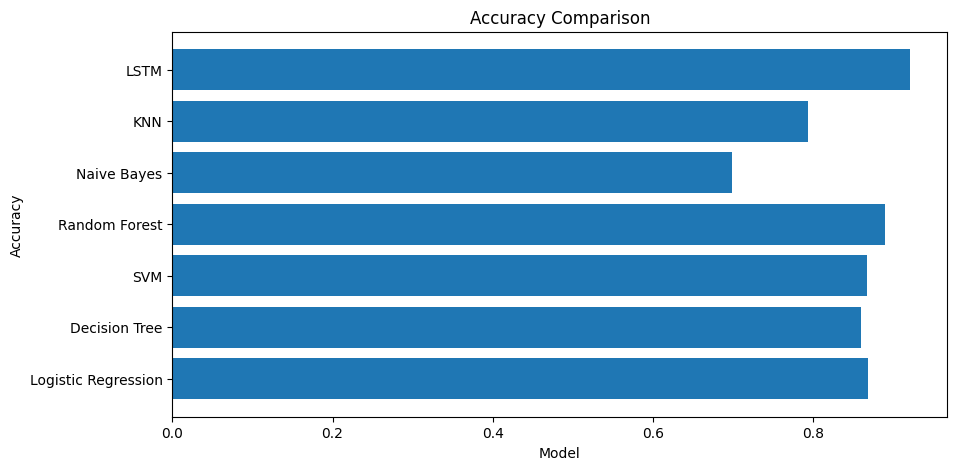

In [105]:
labels = ['Logistic Regression', 'Decision Tree', 'SVM', 'Random Forest', 'Naive Bayes', 'KNN', 'LSTM']

plt.figure(figsize=(10, 5))
plt.barh(labels, accuracies)
plt.title('Accuracy Comparison')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.show()

In [121]:
# Initialize the Lancaster Stemmer from NLTK
stemmer = PorterStemmer()

# Set of valid words from NLTK's words corpus
# valid_words = set(words.words())

# Function to clean text, perform stemming, and filter words not in the corpus
def clean_text(text):
    # Convert to lowercase
    text = text.lower()
    
    # Remove URLs
    text = re.sub(r'http\S+', '', text)

    # Replace non-alphanumeric characters with a single space
    text = re.sub(r'[^a-zA-Z0-9@]', ' ', text)
    
    # remove @ mention 
    # Split the text into words
    words = text.split()

    # Filter out words that start with '@'
    filtered_words = [word for word in words if not word.startswith('@')]

    # Join the filtered words back into a string
    text = ' '.join(filtered_words)

    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))

    # Remove numbers
    text = re.sub(r'\d+', '', text)

    # Tokenize the text
    words = nltk.word_tokenize(text)

    # Filter words not in the corpus
    # cleaned_words = [word for word in words if word in valid_words]

    # Remove stopwords and perform stemming
    stemmed_words = [stemmer.stem(word) for word in words if word not in stopwords.words('english') and '@' not in word]
    
    cleaned_text = ' '.join(stemmed_words)
    
    return cleaned_text
# Apply the cleaning function to the 'content' column
df['cleaned_text'] = df['text'].apply(clean_text)

# Display the cleaned dataset
# df.head()
print(df[['text', 'cleaned_text']].head())

                                                text  \
0                                    That game hurt.   
2     You do right, if you don't care then fuck 'em!   
3                                 Man I love reddit.   
4  [NAME] was nowhere near them, he was by the Fa...   
5  Right? Considering it’s such an important docu...   

                                        cleaned_text  
0                                          game hurt  
2                                 right care fuck em  
3                                    man love reddit  
4                            name nowher near falcon  
5  right consid import document know damn thing b...  


In [106]:


# df.drop("id", axis=1, inplace=True)
# df.drop("author", axis=1, inplace=True)
# df.drop("subreddit", axis=1, inplace=True)
# df.drop("link_id", axis=1, inplace=True)
# df.drop("parent_id", axis=1, inplace=True)
# df.drop("created_utc", axis=1, inplace=True)
# df.drop("rater_id", axis=1, inplace=True)
# df.drop("example_very_unclear", axis=1, inplace=True)

# df = df.melt(id_vars=['text'], var_name='emotion', value_name='value')
# df = df[df['value'] == 1]
# df = df.drop(columns='value')
# print(df.head())

# df.to_csv('cleaned_goemotions.csv', index=False)

In [24]:
for x in df.index:
  if df.loc[x, "sentiment"] == NaN:
    df.drop(x,inplace=True)

In [25]:
df.head()

,tweet_id,sentiment,content,cleaned_content
1,1956967666,sadness,Layin n bed with a headache ughhhh...waitin o...,layin n bed headach ughhhh waitin call
2,1956967696,sadness,Funeral ceremony...gloomy friday...,funer ceremoni gloomi friday
3,1956967789,enthusiasm,wants to hang out with friends SOON!,want hang friend soon
4,1956968416,neutral,@dannycastillo We want to trade with someone w...,want trade someon houston ticket one
5,1956968477,worry,Re-pinging @ghostridah14: why didn't you go to...,ping go prom bc bf like friend


In [223]:
%pip install BeautifulSoup4 scikit-learn textblob 
import requests
from bs4 import BeautifulSoup
import pandas as pd
from textblob import TextBlob
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score


[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: C:\Users\nicos\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


Multinomial NB

In [300]:
# Load the training data from the CSV file
df_train_multinomial = df

# Preprocess the training data
x = df_train_multinomial['cleaned_text']
y = df_train_multinomial['emotion']

# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=125)

# Make model training pipeline
clf = make_pipeline(
    TfidfVectorizer(),
    MultinomialNB(fit_prior=True),
)

# Fit the model to the training data
clf.fit(X_train, y_train)

# scores = cross_val_score(clf, x, y, cv=5)
# print('Cross-validation accuracy: ', scores.mean())

# Predict on the test data
clf.fit(x, y)
y_pred = clf.predict(X_test)
# print(y_pred)
# print(y_test)
# Evaluate the accuracy of the classifier
# print(classification_report(y_test, y_pred))
print(metrics.accuracy_score(y_test, y_pred))
# accuracy = metrics.accuracy_score(y_test, y_pred)
# print(f"Accuracy: {accuracy}")


0.28097105197297073


K Nearest Neighbors

In [302]:
# Load the training data from the CSV file
df_train_multinomial = df

# Preprocess the training data
x = df_train_multinomial['cleaned_text']
y = df_train_multinomial['emotion']

# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.05, random_state=42)

# Make model training pipeline
clf = make_pipeline(
    TfidfVectorizer(), 
    KNeighborsClassifier(n_neighbors=5, weights='distance'),
)

# Fit the model to the training data
clf.fit(X_train, y_train)
# clf.fit(x, y)

# scores = cross_val_score(clf, X_test, y_test, cv=5)
# print('Cross-validation accuracy: ', scores)

# Predict on the test data
y_pred = clf.predict(X_test)
# print(y_pred)
# print(y_test)
# Evaluate the accuracy of the classifier
# print(classification_report(y_test, y_pred))
print(metrics.accuracy_score(y_test, y_pred))


0.16182849516182848


Random Forest Classifier

In [315]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from functools import reduce

def generate_rf(X_train, y_train, X_test, y_test):
    # rf = make_pipeline(
    vectorizer = TfidfVectorizer()
    vectorized = vectorizer.fit_transform(X_train)
    rf = RandomForestClassifier(n_estimators=7, min_samples_leaf=3, random_state=42)
    rf.fit(vectorized, y_train)
    return rf

def combine_rfs(rf_a, rf_b):
    rf_a.estimators_ += rf_b.estimators_
    rf_a.n_estimators = len(rf_a.estimators_)
    return rf_a

df_train_multinomial = df

# Preprocess the training data
x = df_train_multinomial['cleaned_text']
y = df_train_multinomial['emotion']
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=125)


rfs = [generate_rf(X_train, y_train, X_test, y_test) for i in range(10)]
rf_combined = reduce(combine_rfs, rfs)

vectorizer = TfidfVectorizer()
vectorized = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

y_pred = rf_combined.predict(X_test)

print(metrics.accuracy_score(y_test, y_pred))

0.3457078501710186


In [44]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB

# Load the training data from the CSV file
df_train_gaussian = df

# Preprocess the training data
x = df_train_gaussian['cleaned_content']
y = df_train_gaussian['sentiment']

# using count vectorizer
vectorizer = CountVectorizer(preprocessor=lambda x: x, tokenizer=lambda x: x)
x_train_vectorized = vectorizer.fit_transform(x)

# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(x_train_vectorized, y, test_size=0.2, random_state=42)

# Initialize the Gaussian Naive Bayes classifier
gnb = GaussianNB()

# Train the classifier on the training data
gnb.fit(X_train.toarray(), y_train)

# Predict on the test data
y_pred = gnb.predict(X_test.toarray())

# Evaluate the accuracy of the classifier
accuracy = metrics.accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")


C:\Users\nicos\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Accuracy: 0.22399489470325462


In [8]:
import json
# Read the JSON data from the file
with open('Crawler_Data.json', 'r') as json_file:
    data = json.load(json_file)

# Initialize an empty list to store comments
comments_array = []

# Loop through each object in the JSON array
for obj in data:
    if "comments" in obj:
        comments_array.extend(obj["comments"])

# Print the comments array
print(comments_array)

["I kept reading people talk about how this deserves a higher rating, so I read it. Long story short, keep it BELOW 4. It is bad. The worst aspect is the writing, not grammer, not diction, the writing itself. How the author writes about the world, the story itself, its just bad.\nIts your generic MC is special but most folks don't know, the big strong people find out. Its nothing special, he even gets a special pet early on.\nIts so forced, the entire novel is just PLOT ARMOR. It has no rhyme or reason. We have MC finding legendary stuff because of an A rank thing. How does this world even function?\nWhat really grinded by gears was a simple thing. I can ignore how the child MC acts like a child. But why is the author using percentages for a concrete number. We know X amount of people are inside, don't use a percentage for how many advanced, and of those how many advanced further, and of those how many died. That is literally a sentence but with % instead.", "I don't know how this is r